In [1]:
include("LiPoSID.jl")
using QuantumOptics
basis = NLevelBasis(2)
using DynamicPolynomials
using Plots

In [2]:
using Pickle
load("gamma_txt.pkl")

8-element Vector{Any}:
 "0.079477"
 "0.25133"
 "0.79477"
 "2.5133"
 "7.9477"
 "25.133"
 "79.477"
 "251.33"

### Load exact data

In [3]:
γᵗˣᵗ = "0.25133"

parentdir = pwd()
data_dir = parentdir*"\\DATA\\"
println(data_dir)

ρᵍ, tᵍ = LiPoSID.get_rho_series(data_dir*"State_B1_2CUT_data.h5", γᵗˣᵗ)
ρᵉ, tᵉ = LiPoSID.get_rho_series(data_dir*"State_B2_2CUT_data.h5", γᵗˣᵗ)
ρˣ, tˣ = LiPoSID.get_rho_series(data_dir*"State_B3_2CUT_data.h5", γᵗˣᵗ)
ρʸ, tʸ = LiPoSID.get_rho_series(data_dir*"State_B4_2CUT_data.h5", γᵗˣᵗ)

@assert tᵍ == tᵉ == tˣ == tʸ 

t = convert(Vector{Float64}, tᵉ)
@assert maximum(diff(t)) ≈ minimum(diff(t)) ≈ t[2]-t[1]
Δt = t[2]-t[1]
t_steps = length(t)

C:\Users\Zakhar\Documents\GitHub\POP_fail\DATA\


3573

### Generate ansatz dynamics

In [4]:
Hᵃⁿᶻ = [ 25.           0
         0             1    ]

γ = parse(Float64, γᵗˣᵗ)

Lᵃⁿᶻ = [ 0    √γ
         0     0. + 0im  ]

ρᵍₐₙ = LiPoSID.Lindblad_time_evolution(basis, ρᵍ[1], t, Hᵃⁿᶻ, [Lᵃⁿᶻ])
ρᵉₐₙ = LiPoSID.Lindblad_time_evolution(basis, ρᵉ[1], t, Hᵃⁿᶻ, [Lᵃⁿᶻ])
ρˣₐₙ = LiPoSID.Lindblad_time_evolution(basis, ρˣ[1], t, Hᵃⁿᶻ, [Lᵃⁿᶻ])
ρʸₐₙ = LiPoSID.Lindblad_time_evolution(basis, ρʸ[1], t, Hᵃⁿᶻ, [Lᵃⁿᶻ]);

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase C:\Users\Zakhar\.julia\packages\SciMLBase\VKnrY\src\retcodes.jl:360
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase C:\Users\Zakhar\.julia\packages\SciMLBase\VKnrY\src\retcodes.jl:360
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase C:\Users\Zakhar\.julia\packages\SciMLBase\VKnrY\src\retcodes.jl:360
┌ Warning: Backwards compatability support of the new return codes to 

### Perform POP SID

In [5]:
#using DynamicPolynomials

@polyvar e[1:2]
@polyvar d[1:2]

    Hˢʸᵐᵇ = [ e[1]               d[1] + im*d[2]
              d[1] - im*d[2]     0.             ]

    Hˢʸᵐᵇₐₙ = [ e[1]   0
                0      0. ]

@polyvar a[1:4]
@polyvar b[1:4]

    Aˢʸᵐᵇ = [ a[1] + im*b[1]           a[2] + im*b[2]
              a[3] + im*b[3]           a[4] + im*b[4]   ]


    Aˢʸᵐᵇₐₙ = [  0       a[1]
                 0       0   ]


#    POP fails for traceless setup 
#    Aˢʸᵐᵇ = [ a[1] + im*b[1]           a[2] + im*b[2]
#             a[3] + im*b[3]          -a[1] - im*b[1]   ]

objₑₓ = 0

for ρ in [ρᵍ, ρᵉ, ρˣ, ρʸ]

    # Convert cut ρ series:
    ρ = convert(Vector{Matrix{ComplexF64}}, ρ)

    objₑₓ += LiPoSID.simpson_obj(ρ, t,  Hˢʸᵐᵇ, [Aˢʸᵐᵇₐₙ])
    
    objₑₓₐₙ += LiPoSID.simpson_obj(ρ, t,  Hˢʸᵐᵇ, [Aˢʸᵐᵇₐₙ])

end # of files (initial states) loop 

objₐₙ = 0

for ρ in [ρᵍₐₙ, ρᵉₐₙ, ρˣₐₙ, ρʸₐₙ]

    # Convert cut ρ series:
    ρ = convert(Vector{Matrix{ComplexF64}}, ρ)

    objₐₙ += LiPoSID.simpson_obj(ρ, t,  Hˢʸᵐᵇ, [Aˢʸᵐᵇ])

end # of files (initial states) loop 


In [6]:
solₑₓⁿᵉʷ, best_methodₑₓⁿᵉʷ = LiPoSID.sos_min_newton(objₑₓ) 
Hˢⁱᵈₑₓ = subs(Hˢʸᵐᵇ, solₑₓⁿᵉʷ)
Lˢⁱᵈₑₓ = subs(Aˢʸᵐᵇ, solₑₓⁿᵉʷ)

************************TSSOS************************
TSSOS is launching...
optimum = 0.0009544266898444371

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Global optimality certified!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
optimum = 0.0009537703852339749
Global optimality certified!
No higher TSSOS hierarchy!


2×2 Matrix{Polynomial{true, ComplexF64}}:
 (0.0432351+1.25631im)    (-0.306777+0.412409im)
 (-0.054595+0.0636553im)  (0.0437085+1.2568im)

In [7]:
best_methodₑₓⁿᵉʷ

"scaled_tssos"

In [8]:
solₐₙⁿᵉʷ, best_methodₐₙⁿᵉʷ = LiPoSID.sos_min_newton(objₐₙ) 
Hˢⁱᵈₐₙ = subs(Hˢʸᵐᵇ, solₐₙⁿᵉʷ)
Lˢⁱᵈₐₙ = subs(Aˢʸᵐᵇ, solₐₙⁿᵉʷ)

************************TSSOS************************
TSSOS is launching...
optimum = 1.3294100959945406e-7
The local solver failed!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
optimum = 5.616549513290196e-7
Global optimality certified!
No higher TSSOS hierarchy!


2×2 Matrix{Polynomial{true, ComplexF64}}:
 (-2.60687+0.825177im)      (-0.0686816+0.496602im)
 (2.07847e-6+1.01374e-6im)  (-2.60687+0.825177im)

In [9]:
best_methodₐₙⁿᵉʷ

"scaled_tssos"

### Generate identified dynamics

In [10]:
ρᵍₐₙˢⁱᵈ = LiPoSID.Lindblad_time_evolution(basis, ρᵍ[1], t, Hˢⁱᵈₐₙ, [Lˢⁱᵈₐₙ])
ρᵉₐₙˢⁱᵈ = LiPoSID.Lindblad_time_evolution(basis, ρᵉ[1], t, Hˢⁱᵈₐₙ, [Lˢⁱᵈₐₙ])
ρˣₐₙˢⁱᵈ = LiPoSID.Lindblad_time_evolution(basis, ρˣ[1], t, Hˢⁱᵈₐₙ, [Lˢⁱᵈₐₙ])
ρʸₐₙˢⁱᵈ = LiPoSID.Lindblad_time_evolution(basis, ρʸ[1], t, Hˢⁱᵈₐₙ, [Lˢⁱᵈₐₙ]);

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase C:\Users\Zakhar\.julia\packages\SciMLBase\VKnrY\src\retcodes.jl:360
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase C:\Users\Zakhar\.julia\packages\SciMLBase\VKnrY\src\retcodes.jl:360
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase C:\Users\Zakhar\.julia\packages\SciMLBase\VKnrY\src\retcodes.jl:360
┌ Warning: Backwards compatability support of the new return codes to 

In [11]:
ρᵍₑₓˢⁱᵈ = LiPoSID.Lindblad_time_evolution(basis, ρᵍ[1], t, Hˢⁱᵈₑₓ, [Lˢⁱᵈₑₓ])
ρᵉₑₓˢⁱᵈ = LiPoSID.Lindblad_time_evolution(basis, ρᵉ[1], t, Hˢⁱᵈₑₓ, [Lˢⁱᵈₑₓ])
ρˣₑₓˢⁱᵈ = LiPoSID.Lindblad_time_evolution(basis, ρˣ[1], t, Hˢⁱᵈₑₓ, [Lˢⁱᵈₑₓ])
ρʸₑₓˢⁱᵈ = LiPoSID.Lindblad_time_evolution(basis, ρʸ[1], t, Hˢⁱᵈₑₓ, [Lˢⁱᵈₑₓ]);

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase C:\Users\Zakhar\.julia\packages\SciMLBase\VKnrY\src\retcodes.jl:360
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase C:\Users\Zakhar\.julia\packages\SciMLBase\VKnrY\src\retcodes.jl:360
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase C:\Users\Zakhar\.julia\packages\SciMLBase\VKnrY\src\retcodes.jl:360
┌ Warning: Backwards compatability support of the new return codes to 

### Consider fidelities

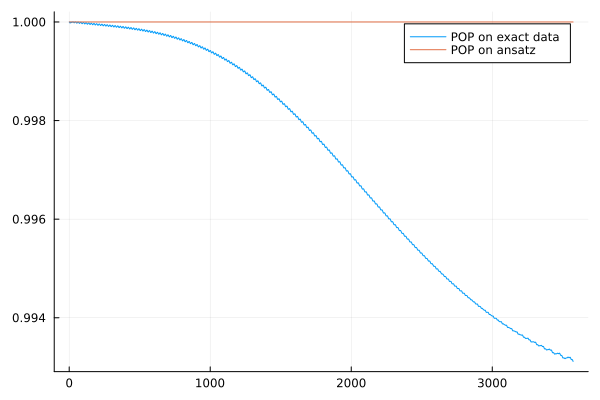

In [12]:
fˢⁱᵈᵉˣ = LiPoSID.fidelity_series(basis, ρˣ, ρˣₑₓˢⁱᵈ )
fˢⁱᵈᵃⁿᶻ = LiPoSID.fidelity_series(basis, ρˣₐₙ, ρˣₐₙˢⁱᵈ)

plot(fˢⁱᵈᵉˣ, label = "POP on exact data")
plot!(fˢⁱᵈᵃⁿᶻ, label = "POP on ansatz")

In [13]:
Fˢⁱᵈᵉˣ = []
Fˢⁱᵈᵃⁿᶻ = []

test_files = ["State_D"*string(n) for n=1:20]

for df in test_files # loop over initial states

    print(df*" ")

    # Read EXACT data series of Kurt data

    ρ, t = LiPoSID.get_rho_series(data_dir*df*"_2CUT_data.h5", string(γᵗˣᵗ))

    ρₑₓ = convert(Vector{Matrix{ComplexF64}}, ρ)
    t = convert(Vector{Float64}, t)

    # Restore data series POP identified

    ρ₀ = ρₑₓ[1]
    ρₑₓˢⁱᵈ = LiPoSID.Lindblad_time_evolution(basis, ρ₀, t, Hˢⁱᵈₑₓ, [Lˢⁱᵈₑₓ])
    
    
    ρₐₙ = LiPoSID.Lindblad_time_evolution(basis, ρ₀, t, Hᵃⁿᶻ, [Lᵃⁿᶻ])    
    ρₐₙˢⁱᵈ = LiPoSID.Lindblad_time_evolution(basis, ρ₀, t, Hˢⁱᵈₐₙ, [Lˢⁱᵈₐₙ])
    

    # Calculating fidelity series
    Fˢⁱᵈᵉˣ = vcat(Fˢⁱᵈᵉˣ, LiPoSID.fidelity_series(basis, ρₑₓ, ρₑₓˢⁱᵈ))
    Fˢⁱᵈᵃⁿᶻ = vcat(Fˢⁱᵈᵃⁿᶻ, LiPoSID.fidelity_series(basis, ρₐₙ, ρₐₙˢⁱᵈ))

end # of files (initial states) df loop  


┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase C:\Users\Zakhar\.julia\packages\SciMLBase\VKnrY\src\retcodes.jl:360
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase C:\Users\Zakhar\.julia\packages\SciMLBase\VKnrY\src\retcodes.jl:360
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase C:\Users\Zakhar\.julia\packages\SciMLBase\VKnrY\src\retcodes.jl:360
┌ Warning: Backwards compatability support of the new return codes to 

State_D1 State_D2 State_D3 State_D4 State_D5 State_D6 State_D7 State_D8 State_D9 State_D10 State_D11 State_D12 State_D13 State_D14 State_D15 State_D16 State_D17 State_D18 State_D19 State_D20 

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase C:\Users\Zakhar\.julia\packages\SciMLBase\VKnrY\src\retcodes.jl:360
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase C:\Users\Zakhar\.julia\packages\SciMLBase\VKnrY\src\retcodes.jl:360
┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase C:\Users\Zakhar\.julia\packages\SciMLBase\VKnrY\src\retcodes.jl:360
┌ Warning: Backwards compatability support of the new return codes to 

In [14]:
Fˢⁱᵈᵉˣ = convert.(Float64, Fˢⁱᵈᵉˣ)
Fˢⁱᵈᵃⁿᶻ = convert.(Float64, Fˢⁱᵈᵃⁿᶻ);

In [15]:
using StatsPlots

In [16]:
violin([Fˢⁱᵈᵉˣ, Fˢⁱᵈᵃⁿᶻ], labels = ["POP on exact" "POP on ansatz"], legend = :bottomright)
title!("γ = "*γᵗˣᵗ)
savefig("violin_"*γᵗˣᵗ*".png")